In [1]:
!pip install tensorflow==2.3.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 320.4 MB 46 kB/s 
     |████████████████████████████████| 2.9 MB 59.0 MB/s 
     |████████████████████████████████| 26.1 MB 1.5 MB/s 
     |████████████████████████████████| 459 kB 70.3 MB/s 
     |████████████████████████████████| 20.1 MB 812 kB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: scipy
    Found existing installation: scipy 1.7.3
    Uninstalling scipy-1.7.3:
      Successfully uninstalled scipy-1.7.3
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
  

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import PIL

import os
from google.colab import drive

In [3]:
!unzip AlzData.zip

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: train/MildDemented/mildDem207.jpg  
  inflating: train/MildDemented/mildDem208.jpg  
  inflating: train/MildDemented/mildDem209.jpg  
  inflating: train/MildDemented/mildDem21.jpg  
  inflating: train/MildDemented/mildDem210.jpg  
  inflating: train/MildDemented/mildDem211.jpg  
  inflating: train/MildDemented/mildDem212.jpg  
  inflating: train/MildDemented/mildDem213.jpg  
  inflating: train/MildDemented/mildDem214.jpg  
  inflating: train/MildDemented/mildDem215.jpg  
  inflating: train/MildDemented/mildDem216.jpg  
  inflating: train/MildDemented/mildDem217.jpg  
  inflating: train/MildDemented/mildDem218.jpg  
  inflating: train/MildDemented/mildDem219.jpg  
  inflating: train/MildDemented/mildDem22.jpg  
  inflating: train/MildDemented/mildDem220.jpg  
  inflating: train/MildDemented/mildDem221.jpg  
  inflating: train/MildDemented/mildDem222.jpg  
  inflating: train/MildDemented/mildDem223.jpg  
  inflating: train/MildDemented/mil

In [4]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

print(tf.version)

Number of replicas: 1
<module 'tensorflow._api.v2.version' from '/usr/local/lib/python3.7/dist-packages/tensorflow/_api/v2/version/__init__.py'>


In [5]:
IMAGE_SIZE = [176,208]
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
EPOCHS = 10
AUTOTUNE = tf.data.experimental.AUTOTUNE


In [6]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    './train',
    validation_split = 0.2,
    subset = 'training',
    seed = 1337,
    image_size = IMAGE_SIZE,
    batch_size = BATCH_SIZE

)

Found 5121 files belonging to 4 classes.
Using 4097 files for training.


In [7]:
valid_ds = tf.keras.preprocessing.image_dataset_from_directory(
    './train',
    validation_split = 0.2,
    subset = 'validation',
    seed = 1337,
    image_size = IMAGE_SIZE,
    batch_size = BATCH_SIZE

)

Found 5121 files belonging to 4 classes.
Using 1024 files for validation.


In [8]:
list_dir_classes = os.listdir('./train')
list_dir_classes
#or
class_names = ['MildDemented', 'ModerateDemented', 'NonDemented','VeryMildDemented']
list_dir_classes

['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']

In [9]:
train_ds.class_names = class_names
valid_ds.class_names = class_names
NUM_CLASSES = len(class_names)



In [10]:
train_ds

<BatchDataset shapes: ((None, 176, 208, 3), (None,)), types: (tf.float32, tf.int32)>

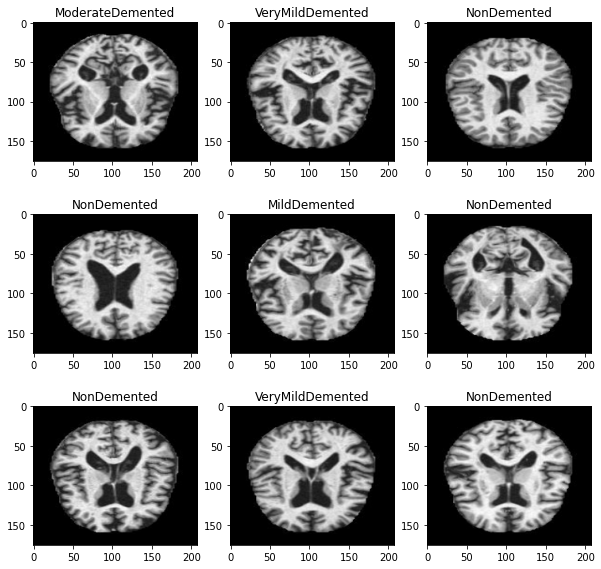

In [11]:
plt.figure(figsize = (10,10))

for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.title(train_ds.class_names[labels[i]])

In [12]:
def one_hot_label(image,label):
  label = tf.one_hot(label, NUM_CLASSES)
  return image,label

train_ds = train_ds.map(one_hot_label, num_parallel_calls = AUTOTUNE)
valid_ds = valid_ds.map(one_hot_label, num_parallel_calls = AUTOTUNE)



In [13]:
train_ds = train_ds.cache().prefetch(buffer_size = AUTOTUNE)
valid_ds = valid_ds.cache().prefetch(buffer_size = AUTOTUNE)

In [14]:
NUM_IMAGES = []   

for label in class_names:
  dir_name = './train/' + label[:-2] + 'ed'
  NUM_IMAGES.append(len([name for name in os.listdir(dir_name)]))

In [15]:
NUM_IMAGES #imbalanced data

[717, 52, 2560, 1792]

In [16]:
#Conv block

def conv_block(filters):
  block = tf.keras.Sequential([
  tf.keras.layers.SeparableConv2D(filters,3,activation = "relu",padding = "same"),
  tf.keras.layers.SeparableConv2D(filters,3,activation = "relu",padding = "same"),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPool2D()

  ])
  return block

def Dense_block(units,dropout_rate):
  block = tf.keras.Sequential(
      [
       tf.keras.layers.Dense(units,activation = "relu"),
       tf.keras.layers.BatchNormalization(),
       tf.keras.layers.Dropout(dropout_rate)


      ]
  )
  return block

In [17]:
def build_model():
  model = tf.keras.Sequential([
  tf.keras.layers.Input(shape = (*IMAGE_SIZE,3)),                    
  tf.keras.layers.SeparableConv2D(16,3,activation = "relu",padding = "same"),
  tf.keras.layers.SeparableConv2D(16,3,activation = "relu",padding = "same"),
  tf.keras.layers.MaxPool2D(),
  conv_block(32),
  conv_block(64),
  conv_block(128),
  tf.keras.layers.Dropout(0.2),

  conv_block(256),
  tf.keras.layers.Dropout(0.2),

  tf.keras.layers.Flatten(),
  Dense_block(512,0.7),
  Dense_block(128,0.5),
  Dense_block(64,0.3),
  tf.keras.layers.Dense(NUM_CLASSES,activation = "softmax")
  ])
  return model

In [18]:
with strategy.scope():
  model = build_model()
  METRICS = [tf.keras.metrics.AUC(name = 'auc')]
  model.compile(
      optimizer = 'adam',
      loss = tf.losses.CategoricalCrossentropy(),
      metrics = METRICS
  )

In [19]:


def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 20)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("alzheimer_model.h5",
                                                    save_best_only=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,
                                                     restore_best_weights=True)

In [20]:
#Training

history = model.fit(
    train_ds,
    validation_data = valid_ds,
    callbacks = [checkpoint_cb, early_stopping_cb, lr_scheduler],
    epochs = EPOCHS
)

Epoch 1/10
257/257 [==============================] - 35s 135ms/step - loss: 1.0970 - auc: 0.7875 - val_loss: 1.7411 - val_auc: 0.5774
Epoch 2/10
257/257 [==============================] - 30s 116ms/step - loss: 0.9532 - auc: 0.8210 - val_loss: 56.4215 - val_auc: 0.3783
Epoch 3/10
257/257 [==============================] - 30s 118ms/step - loss: 0.9701 - auc: 0.8138 - val_loss: 5.4768 - val_auc: 0.6716
Epoch 4/10
257/257 [==============================] - 31s 120ms/step - loss: 0.9708 - auc: 0.8124 - val_loss: 12.7911 - val_auc: 0.6670
Epoch 5/10
257/257 [==============================] - 31s 120ms/step - loss: 0.9441 - auc: 0.8237 - val_loss: 1.1332 - val_auc: 0.8063
Epoch 6/10
257/257 [==============================] - 31s 119ms/step - loss: 0.9369 - auc: 0.8274 - val_loss: 1.0117 - val_auc: 0.8214
Epoch 7/10
257/257 [==============================] - 30s 118ms/step - loss: 0.9147 - auc: 0.8358 - val_loss: 1.7007 - val_auc: 0.8016
Epoch 8/10
257/257 [==============================] -